In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from tqdm import tqdm 
import warnings
warnings.filterwarnings('ignore')
import seaborn as sn
import time 
import matplotlib.animation as ani

### load & first clean

In [3]:
dff = pd.read_excel('Datensätze.xlsx')
dff.replace(0, float('NaN'), inplace=True)
dff.dropna(inplace=True)

### Formula to add Stock/Bond Ratio to df

In [4]:
def Add_SBRatioRank(df, n):
# calculate and add Stock/Bond Ratio Rank
# first calculate all in a seperate 
    
    df['Stock_r'] = np.log(df['Stock_P']/df['Stock_P'].shift(1))
    df['Bond_r'] = np.log(df['Bond_P']/df['Bond_P'].shift(1))
    
    df['SB_Ratio'] = df['Stock_P']/df['Bond_P']
    df['SB_Ratio_Rank'] = (df['SB_Ratio']-df['SB_Ratio'].rolling(n).min())/(df['SB_Ratio'].rolling(n).max()-df['SB_Ratio'].rolling(n).min())

    return df

### Formula to add RiskPremium to df

In [5]:
def Add_RiskPremiumRank(df, n):
# calculate risk premium Rank

    df['Risk_Premium'] = ((df['Earnings']/df['SPX_P']) - df['US10Y_Yield'])*-1
    df['Risk_Premium_Rank'] = (df['Risk_Premium']-df['Risk_Premium'].rolling(n).min())/(df['Risk_Premium'].rolling(n).max()-df['Risk_Premium'].rolling(n).min())
    return df

### Formula to Add Put/Call Impl Vol to df

In [6]:
def Add_PutCallVolRank(df, n):
# calculate Put/Call Implied Volatility Rank

    df['SPX_Impl_Spread_P-C_Rank'] = -1*(df['SPX_Impl_Spread_P-C']-df['SPX_Impl_Spread_P-C'].rolling(n).min())/(df['SPX_Impl_Spread_P-C'].rolling(n).max()-df['SPX_Impl_Spread_P-C'].rolling(n).min())+1
    
    return df


### Formula to add High Yield CDS to df

In [7]:
def Add_HYCDSRank(df, n):
# calculate High Yield Credit Default Swap Rank
    
    df['HY_CDS_Rank'] = -1*(df['HY_CDS']-df['HY_CDS'].rolling(n).min())/(df['HY_CDS'].rolling(n).max()-df['HY_CDS'].rolling(n).min())+1
    
    return df

### Formula to add Vola Curve Slope Z Score to df

In [8]:
def Add_Vola_CurveRank(df,n):
# calculate Vola Curve Rank
    
    df['Vola_Slope_Rank'] = (df['Vola_Slope']-df['Vola_Slope'].rolling(n).min())/(df['Vola_Slope'].rolling(n).max()-df['Vola_Slope'].rolling(n).min())
    
    return df

In [9]:
def Add_DollarRank(df,n):
# calculate Dollar Rank

    df['Dollar_Rank'] = -1*(df['Dollar ']-df['Dollar '].rolling(n).min())/(df['Dollar '].rolling(n).max()-df['Dollar '].rolling(n).min())+1
    
    return df

In [10]:
def MA(serIn, n):
    
    if n == 0:
        serOut = serIn
    else:
        serOut = serIn.rolling(n).mean()
    return serOut

In [11]:
def do_Strat(dff, n1=110, n2=150, n3=250, n4=0, n5=150, n6=0, n7=250, a1=16, a2=8, a3=16, a4=16, a5=16, a6=16, a7=16,evaluate=True):

# do the strategy and chose 

# copy the dataframe to use 
    df = dff.copy()

# calculate future Returns
    df['1M nReturn'] = np.log(df['Stock_P'].shift(-21)/df['Stock_P'].shift(-1))
    df['3M nReturn'] = np.log(df['Stock_P'].shift(-61)/df['Stock_P'].shift(-1))
    df['6M nReturn'] = np.log(df['Stock_P'].shift(-121)/df['Stock_P'].shift(-1))
    df['Stock_MA'] = df.Stock_P.rolling(80).mean()

# calculate values 
    df = Add_SBRatioRank(df, n1)
    df = Add_RiskPremiumRank(df, n2)
    df = Add_PutCallVolRank(df, n3)
#     df = Add_HYCDSRank(df, n4)
    df = Add_Vola_CurveRank(df, n5)
#     df = Add_DollarRank(df,n6)
    
    df['SB_Ratio_Rank'] = MA(df['SB_Ratio_Rank'],a1)
    df['Risk_Premium_Rank'] = MA(df['Risk_Premium_Rank'], a2)
    df['Vola_Slope_Rank'] = MA(df['Vola_Slope_Rank'], a3)
#     df['HY_CDS_Rank'] = MA(df['HY_CDS_Rank'], a4)
    df['SPX_Impl_Spread_P-C_Rank'] = MA(df['SPX_Impl_Spread_P-C_Rank'],a5)
#     df['Dollar_Rank'] = MA(df['Dollar_Rank'], a6)

# create Score
    df['Score'] = df['SB_Ratio_Rank']+df['Risk_Premium_Rank']+df['Vola_Slope_Rank']*1.5+df['SPX_Impl_Spread_P-C_Rank']*1.5
#     *1.2+df['HY_CDS_Rank'] +df['Dollar_Rank']
    df['Score_MA'] = df['Score'].rolling(n7).mean()
    df['Score_Z'] = (df['Score']-df['Score_MA'])/df['Score'].rolling(n7).std()
    df['Score_Rank'] = (df['Score']-df['Score'].rolling(n7).min())/(df['Score'].rolling(n7).max()-df['Score'].rolling(n7).min())
    df['Score_Rank'] = MA(df['Score_Rank'],a7)**2

# drop NaN    
    if evaluate:
        df.dropna(inplace=True)

    return df

          6-Month Return

6M Sell Return is 2.0% on average from 7 signals
Hit-rate: 0.86

6M Buy Return is 11.1% on average from 7 signals
Hit-rate: 1.0

The Average 6M Return is 5.3%



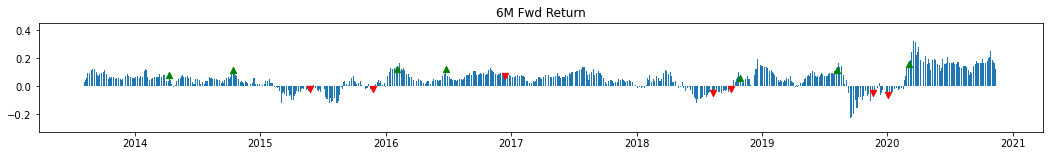

          --------------------

          3-Month Return

3M Sell Return is 6.5% on average from 7 signals
Hit-rate: 0.71

3M Buy Return is 5.8% on average from 7 signals
Hit-rate: 0.86


The Average 3M Return is 2.6%



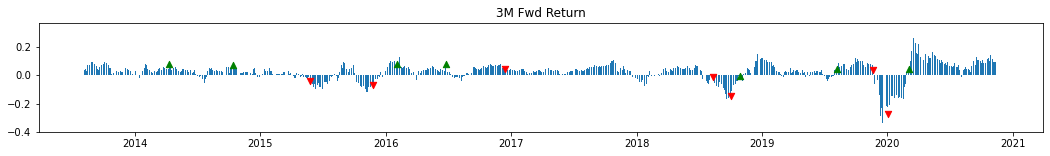

          --------------------



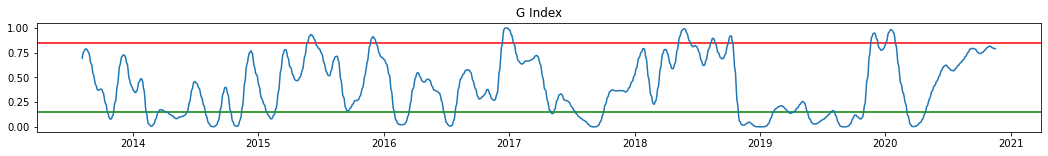

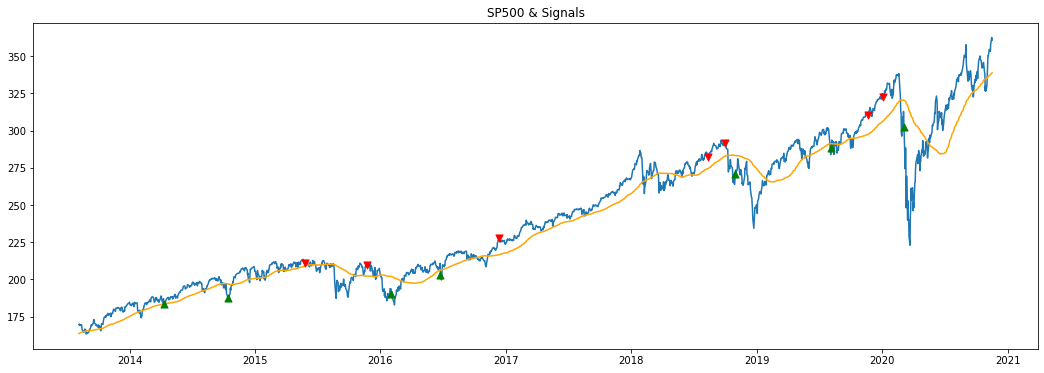

In [82]:
buy = 0.15
sell = 0.85

%matplotlib inline 

df = do_Strat(dff)

df['SELL'] = (df['Score_Rank'] > sell) & (df['Score_Rank'].shift(1) < sell) & (df['Stock_P']>df['Stock_MA'])
df['BUY'] = (df['Score_Rank'] < buy) & (df['Score_Rank'].shift(1)> buy)  &(df['Stock_P']<df['Stock_MA'])

print("          6-Month Return")
print('')
print(f"6M Sell Return is {round(((df['6M nReturn']*df['SELL']*-1).sum()/df['SELL'].sum())*100,1)}% on average from {df['SELL'].sum()} signals")
print(f"Hit-rate: {round(len([num for num in (df['6M nReturn']*df['SELL']) if num < 0])/len([num for num in (df['6M nReturn']*df['SELL']) if num != 0]),2)}")
print('')
print(f"6M Buy Return is {round(((df['6M nReturn']*df['BUY']).sum()/df['BUY'].sum())*100,1)}% on average from {df['BUY'].sum()} signals")
print(f"Hit-rate: {round(len([num for num in (df['6M nReturn']*df['BUY']) if num > 0.052])/len([num for num in (df['6M nReturn']*df['BUY']) if num != 0]),2)}")
print('')
print(f"The Average 6M Return is {round(df['6M nReturn'].sum()/df['6M nReturn'].count()*100, 1)}%")
print('')
plt.figure(figsize=(18, 2))
plt.bar(df['Date'], df['6M nReturn'], width=1, zorder=0)
plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], '6M nReturn'].values, label='skitscat', color='red', s=40, marker="v", zorder=10)
plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], '6M nReturn'].values, label='skitscat', color='green', s=40, marker="^", zorder=10)
plt.title('6M Fwd Return')
plt.show()
print('          --------------------')
print('')
print("          3-Month Return")
print('')
print(f"3M Sell Return is {round(((df['3M nReturn']*df['SELL']*-1).sum()/df['SELL'].sum())*100,1)}% on average from {df['SELL'].sum()} signals")
print(f"Hit-rate: {round(len([num for num in (df['3M nReturn']*df['SELL']) if num < 0])/len([num for num in (df['3M nReturn']*df['SELL']) if num != 0]),2)}")
print('')
print(f"3M Buy Return is {round(((df['3M nReturn']*df['BUY']).sum()/df['BUY'].sum())*100,1)}% on average from {df['BUY'].sum()} signals")
print(f"Hit-rate: {round(len([num for num in (df['3M nReturn']*df['BUY']) if num > 0.026])/len([num for num in (df['3M nReturn']*df['BUY']) if num != 0]),2)}")
print('')
print('')
print(f"The Average 3M Return is {round(df['3M nReturn'].sum()/df['3M nReturn'].count()*100, 1)}%")
print('')
plt.figure(figsize=(18, 2))
plt.bar(df['Date'], df['3M nReturn'], width=1, zorder=0)
plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], '3M nReturn'].values, label='skitscat', color='red', s=40, marker="v", zorder=10)
plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], '3M nReturn'].values, label='skitscat', color='green', s=40, marker="^", zorder=10)
plt.title('3M Fwd Return')
plt.show()
print('          --------------------')
print('')

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['Score_Rank'], zorder=10)
plt.axhline(y=buy, color='g', linestyle='-', zorder=0)
plt.axhline(y=sell, color='r', linestyle='-', zorder=0)
plt.title('G Index')
plt.show()

plt.figure(figsize=(18, 6))
plt.plot(df['Date'], df['Stock_P'], zorder=0)
plt.plot(df['Date'], df['Stock_MA'], color='orange', zorder=0)
plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], 'Stock_P'].values, label='skitscat', color='red', s=50, marker="v", zorder=10)
plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], 'Stock_P'].values, label='skitscat', color='green', s=50, marker="^", zorder=10)
plt.title('SP500 & Signals')
plt.show()


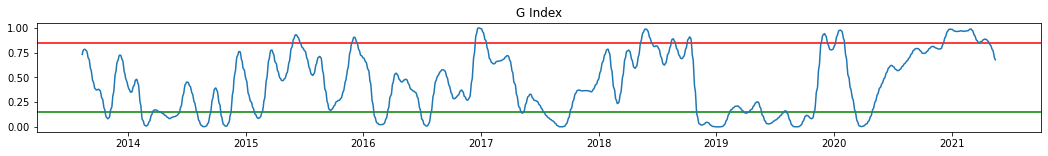

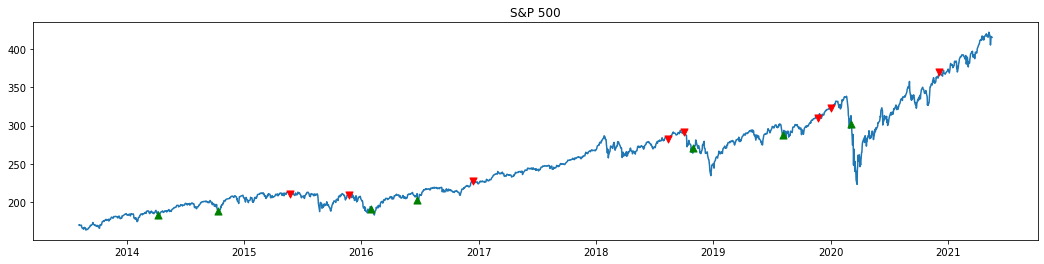

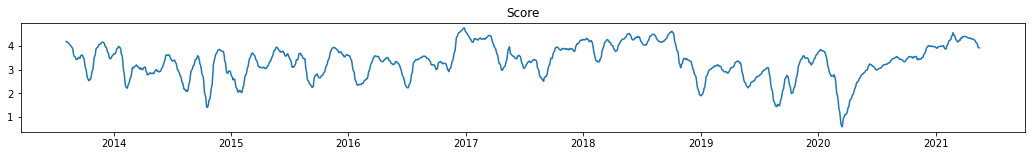

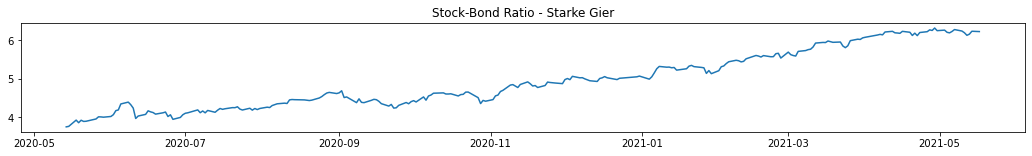

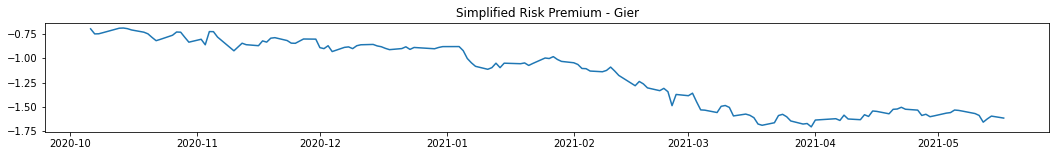

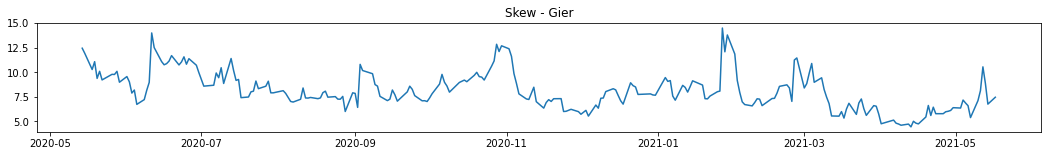

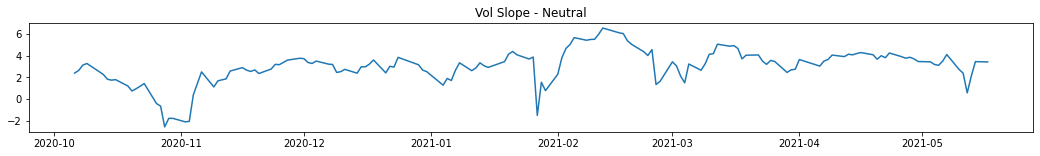

In [110]:
sentiment = {0.2:'Starke Angst', 0.4:'Angst', 0.6:'Neutral', 0.8:'Gier', 1:'Starke Gier'}

df = do_Strat(dff, n1=250, n2=150, n3=250, n5=150, n7=250, a1=16, a2=8, a3=16, a5=16, a7=16, evaluate=False)

buy=0.15
sell=0.85


df['SELL'] = (df['Score_Rank'] > sell) & (df['Score_Rank'].shift(1) < sell) & (df['Stock_P']>df['Stock_MA'])
df['BUY'] = (df['Score_Rank'] < buy) & (df['Score_Rank'].shift(1)> buy) &(df['Stock_P']<df['Stock_MA'])

df.dropna(subset=['Score_Rank'], inplace=True)

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], MA(df['Score_Rank'],5), zorder=10)
plt.axhline(y=buy, color='g', linestyle='-', zorder=0)
plt.axhline(y=sell, color='r', linestyle='-', zorder=0)
plt.title('G Index')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(df['Date'], df['Stock_P'])
plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], 'Stock_P'].values, label='skitscat', color='red', s=50, marker="v", zorder=10)
plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], 'Stock_P'].values, label='skitscat', color='green', s=50, marker="^", zorder=10)
plt.title('S&P 500')
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'], df['Score'])
plt.title('Score')
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'].iloc[-250:], df['SB_Ratio'].iloc[-250:])
plt.title(f"Stock-Bond Ratio - {sentiment[round(df['SB_Ratio_Rank'].iloc[-1]*5)/5]}")
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'][-150:], df['Risk_Premium'][-150:]*-1)
plt.title(f"Simplified Risk Premium - {sentiment[round(df['Risk_Premium_Rank'].iloc[-1]*5)/5]}")
plt.show()

plt.figure(figsize=(18, 2))
plt.plot(df['Date'][-250:], df['SPX_Impl_Spread_P-C'][-250:])
plt.title(f"Skew - {sentiment[round(df['SPX_Impl_Spread_P-C_Rank'].iloc[-1]*5)/5]}")
plt.show()


plt.figure(figsize=(18, 2))
plt.plot(df['Date'][-150:],df['Vola_Slope'][-150:])
plt.title(f"Vol Slope - {sentiment[round(df['Vola_Slope_Rank'].iloc[-1]*5)/5]}")
plt.show()


50 0
19.267855661000798


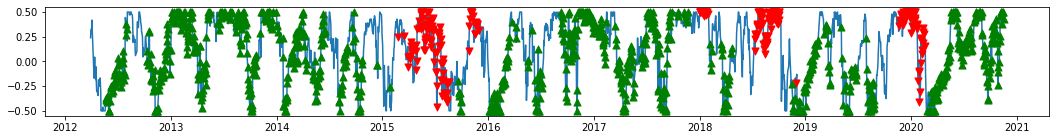

60 0
19.63022888167504


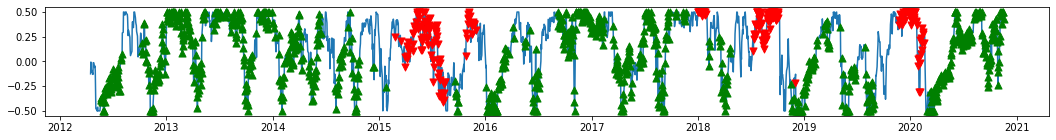

70 0
20.09020455317093


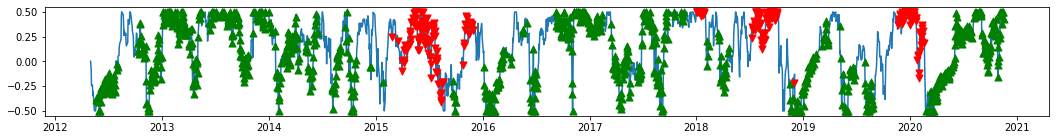

80 0
19.64168801729499


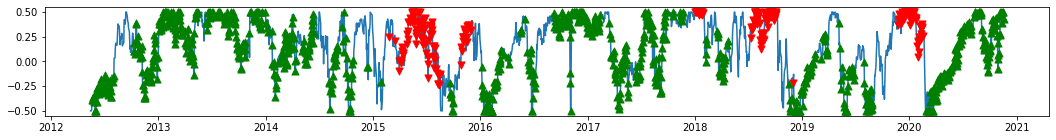

90 0
19.61885909293784


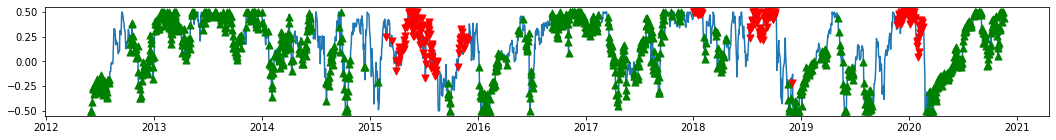

100 0
19.359417676158362


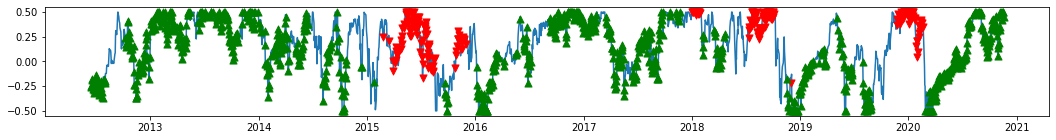

110 0
19.126071010545957


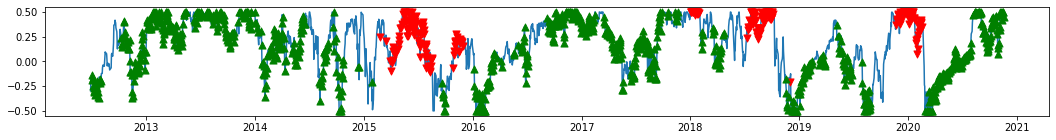

120 0
19.19150268425724


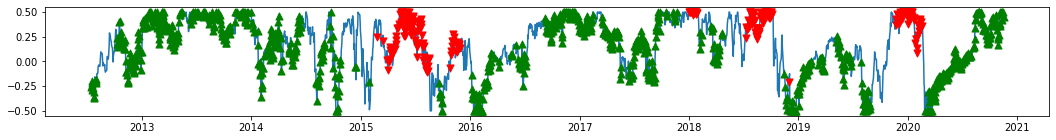

130 0
18.83482893740123


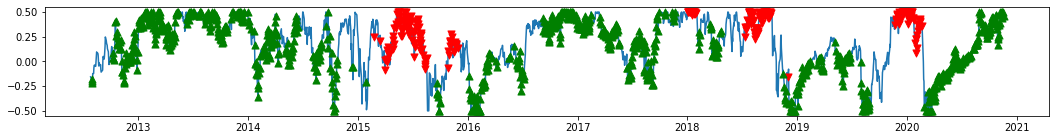

140 0
19.08656760155465


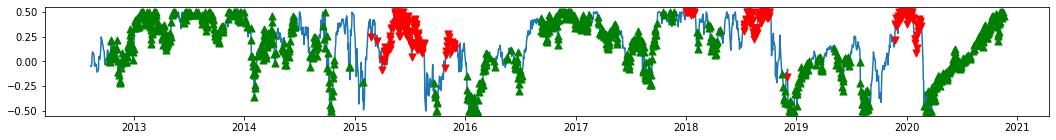

150 0
19.09934886238245


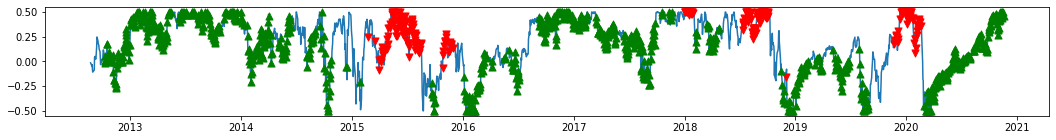

160 0
18.86187045920422


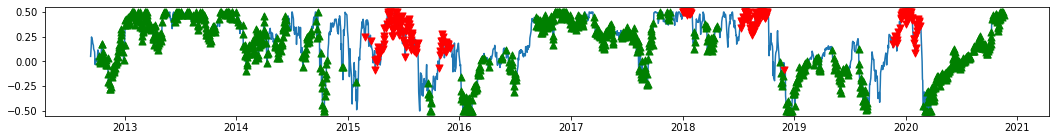

170 0
18.538508617591273


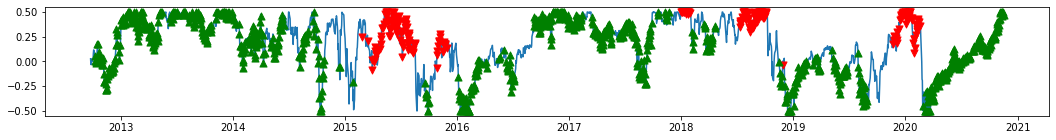

180 0
17.822147592039673


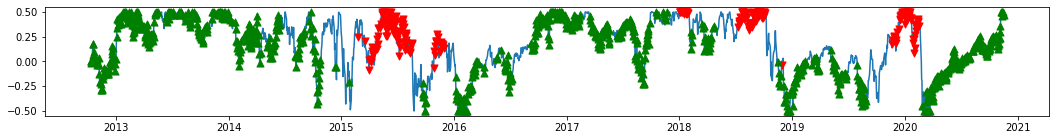

190 0
17.453463505070765


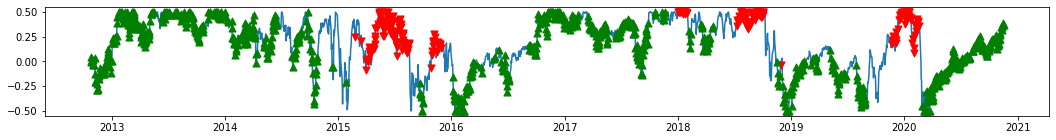

200 0
17.28973351065895


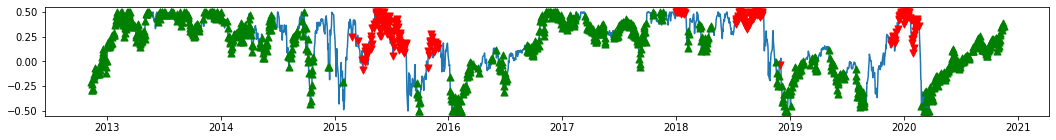

210 0
17.30088590730073


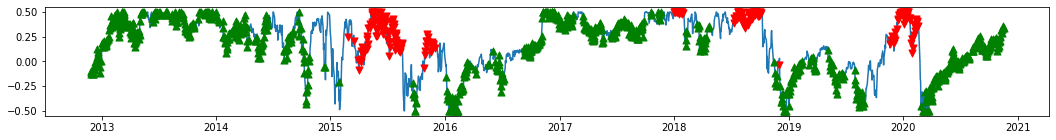

220 0
17.421506599112877


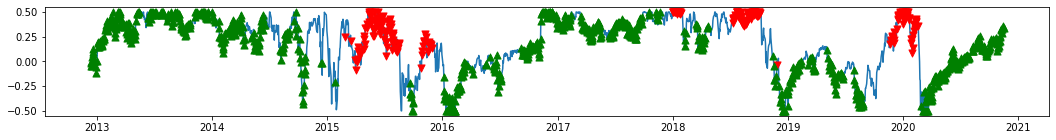

230 0
17.648851252043972


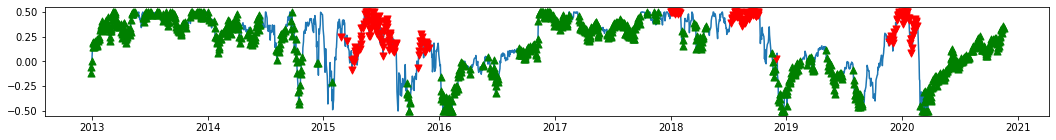

240 0
17.896514434009646


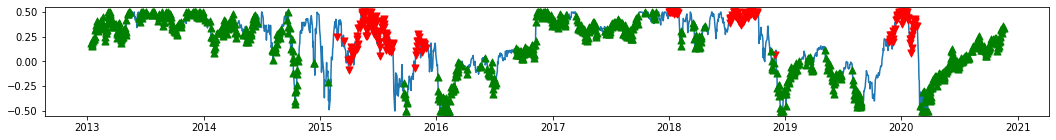

250 0
17.932080719080624


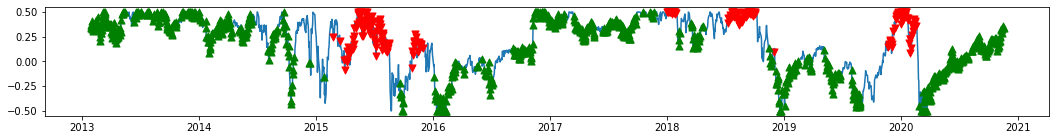

260 0
17.721733323486376


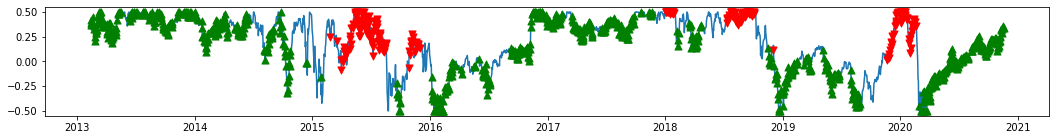

270 0
17.556444501965927


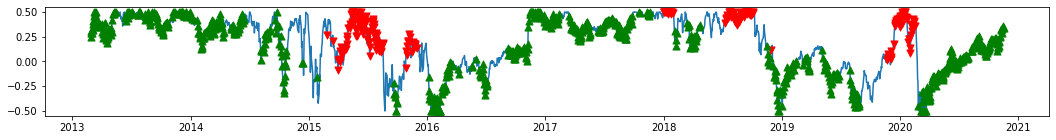

280 0
17.54553547023852


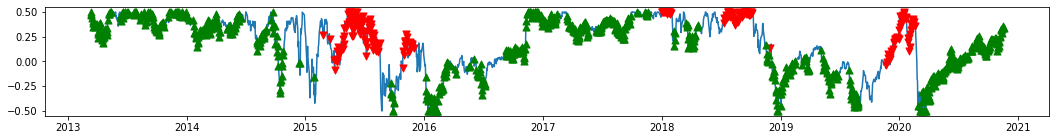

290 0
17.528000113694628


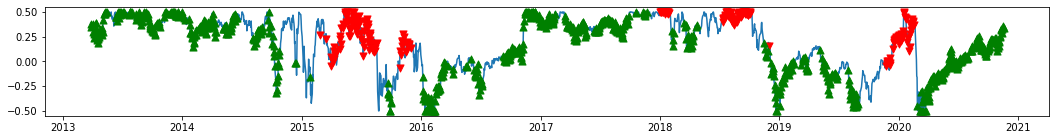

50 5
18.290958503884816


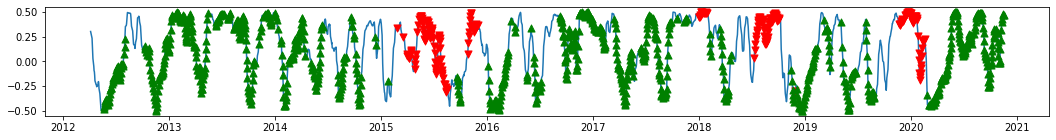

60 5
19.037789815515318


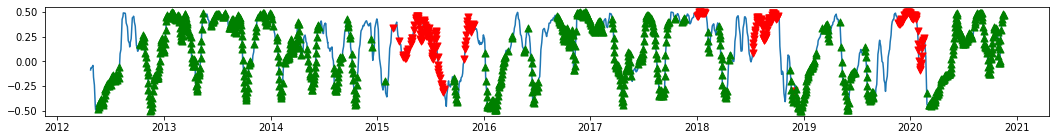

70 5
19.68544880173151


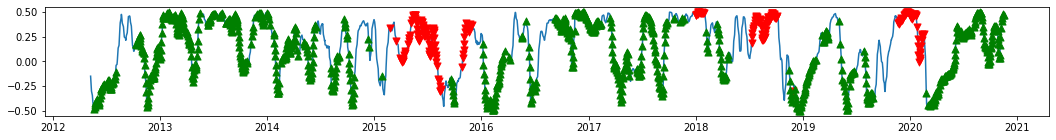

80 5
19.203709983481026


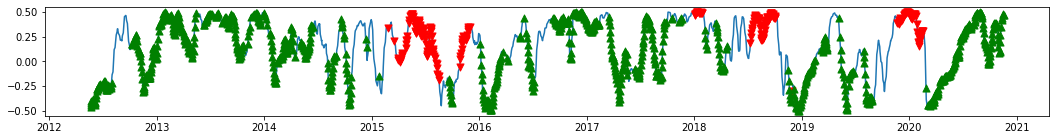

90 5
19.381938942260426


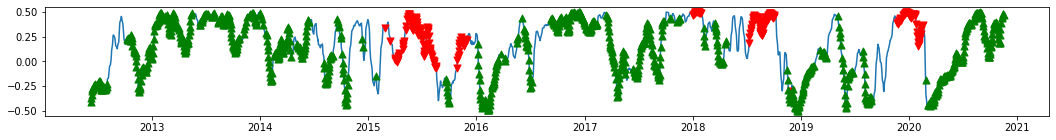

100 5
19.12179205227683


KeyboardInterrupt: 

In [113]:
res = {}

options = ['SB_Ratio_Rank', 'Risk_Premium_Rank', 'SPX_Impl_Spread_P-C_Rank', 'HY_CDS_Rank','Vola_Slope_Rank', 'Dollar_Rank']

for i in options:
    results = {}
    for j in range(0, 26, 5):
        for k in range(50, 300, 10):
            
            df = do_Strat(dff, n1=k, n2=k, n3=k, n4=k, n5=k, n6=k)

            df[i] = MA(df[i],j+1)
            df[i] = df[i] - 0.5 

            df['SELL'] = (df['6M nReturn'] < 0) & (df['3M nReturn'] < 0)
            df['BUY'] = (df['6M nReturn'] > 0.05) & (df['3M nReturn'] > 0.02)

            print(k, j)

            value = ((df['6M nReturn'] * df[i])* ((df[i] > 0.2))).sum()

            print(value)
            results[str(k)+', '+str(j)] = value

            plt.figure(figsize=(18, 2))
            plt.plot(df['Date'], df[i])
            plt.scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], i].values, label='skitscat', color='red', s=50, marker="v", zorder=10)
            plt.scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], i].values, label='skitscat', color='green', s=50, marker="^", zorder=10)
            plt.show()
    print(min(list(results.values())))
    print(list(results.keys())[list(results.values()).index(min(list(results.values())))])
    res[i] = list(results.keys())[list(results.values()).index(min(list(results.values())))]


In [195]:
res

{'SB_Ratio_Rank': '50, 25',
 'Risk_Premium_Rank': '180, 25',
 'SPX_Impl_Spread_P-C_Rank': '50, 25',
 'HY_CDS_Rank': '50, 20',
 'Vola_Slope_Rank': '50, 25',
 'Dollar_Rank': '50, 25'}

In [57]:
df_new = df[['3M nReturn', 'SB_Ratio_Rank', 'Risk_Premium_Rank', 'HY_CDS_Rank','SPX_Impl_Spread_P-C_Rank', 'Vola_Slope_Rank', 'Dollar_Rank', 'Stock_P']]

corrMatrix = df_new.corr()

sn.heatmap(corrMatrix, annot=True)

plt.show()

In [111]:
import statsmodels.api as sm

slr_model = sm.OLS(df['6M nReturn'], df[[ 'Risk_Premium', 'Vola_Slope', 'Dollar ', 'HY_CDS', 'SB_Ratio', 'SPX_Impl_Spread_P-C',]])
slr_reg = slr_model.fit()
print(slr_reg.summary())

# 

                                 OLS Regression Results                                
Dep. Variable:             6M nReturn   R-squared (uncentered):                     nan
Model:                            OLS   Adj. R-squared (uncentered):                nan
Method:                 Least Squares   F-statistic:                                nan
Date:                Wed, 02 Jun 2021   Prob (F-statistic):                         nan
Time:                        12:45:35   Log-Likelihood:                             nan
No. Observations:                1925   AIC:                                        nan
Df Residuals:                    1919   BIC:                                        nan
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

In [12]:
from matplotlib.animation import FuncAnimation

options = ['SB_Ratio_Rank', 'Risk_Premium_Rank', 'SPX_Impl_Spread_P-C_Rank', 'HY_CDS_Rank','Vola_Slope_Rank', 'Dollar_Rank']

option = 'Risk_Premium_Rank'

values = {}
for i in np.linspace(10,250,25):
    i = int(i)
    df = do_Strat(dff, n1=i, n2=i, n3=i, n4=i, n5=i, n6=i)
    values[i] = df[option], df['Date'], df['6M nReturn']

%matplotlib tk

# fig, ax = plt.subplots(figsize = (18,2))

# x = np.arange(0,19,0.1)

# ax.plot(x, x+np.random.normal(0,3.0,len(x))) 

# 
    
# def update(i):
#     label = 'timestep{0}'.format(i+1)
#     line.set_ydata(x-5+i)
#     return line, ax

# anim = FuncAnimation(fig, update, repeat=True, frames=np.arange(0,10), interval=500)

# plt.show()
    
    
fig, axs = plt.subplots(2, figsize=(18, 4))

axs[0].set_ylim(0,1)





def animation_frame(i):
    
    axs[0].lines = []
    
    df = do_Strat(dff, n1=i, n2=i, n3=i, n4=i, n5=i, n6=i)
    
    df['SELL'] = (df['6M nReturn'] < 0) & (df['3M nReturn'] < 0)
    df['BUY'] = (df['6M nReturn'] > 0.07) & (df['3M nReturn'] > 0.05)
    
    x, y, z = df[option], df['Date'], df['6M nReturn']
    
    y = y.to_list()
    x = x.to_list()
    z = z.to_list()
    
    axs[0].scatter(df.loc[df['SELL'], 'Date'].values, df.loc[df['SELL'], 'Risk_Premium_Rank'].values, label='skitscat', color='red', s=50, marker="v")
    axs[0].scatter(df.loc[df['BUY'], 'Date'].values, df.loc[df['BUY'], 'Risk_Premium_Rank'].values, label='skitscat', color='green', s=50, marker="^")
    
    axs[0].set_title(i)
    line, = axs[0].plot(x, y, color='#add8e6', linewidth=1)
    
    axs[1].bar(x, z, color='#add8e6', width =1)
    
    

    return line,

animation = FuncAnimation(fig, func=animation_frame, frames=np.arange(10,260,10), interval=500)

plt.show()



### Use Slider to decide on Values 

In [14]:
from matplotlib.widgets import Slider, Button

%matplotlib tk

option = options[4]

def f(moving_average, period):
    df = do_Strat(dff, a1 = moving_average, a2 = moving_average, a3 = moving_average, a4 = moving_average, a5 = moving_average, a6 = moving_average, n1=period, n2=period, n3=period, n4=period, n5=period, n6=period)
    x = df['Date']
    y = df[option]
    z = df['Stock_P']
    return x, y, z


# Define initial parameters
init_moving_average = 5
init_period = 50

# Create the figure and the line that we will manipulate
fig, axs = plt.subplots(2, figsize=(18,6))
x, y, z = f(init_moving_average, init_period)
line, = plt.plot(x, y, lw=1)
axs[1].set_xlabel('Date')
axs[0].plot(x, z, lw=1)

axcolor = 'lightgoldenrodyellow'
axs[1].margins(x=0)
axs[0].margins(x=0)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left=0.25, bottom=0.25)

# Make a horizontal slider to control the frequency.
axma = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
ma_slider = Slider(
    ax=axma,
    label='Moving Average',
    valmin=0,
    valmax=30,
    valstep=1,
    valinit=init_moving_average
)

# Make a vertically oriented slider to control the amplitude
axper = plt.axes([0.1, 0.25, 0.0225, 0.63], facecolor=axcolor)
per_slider = Slider(
    ax=axper,
    label="Rank Period",
    valmin=100,
    valmax=300,
    valstep=20,
    valinit=init_period,
    orientation="vertical"
)


# The function to be called anytime a slider's value changes
def update(val):
    x, y, z = f(ma_slider.val, per_slider.val)
    line.set_data(x, y)
    fig.canvas.draw_idle()
    


# register the update function with each slider
ma_slider.on_changed(update)
per_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    ma_slider.reset()
    per_slider.reset()
button.on_clicked(reset)

plt.show()


In [15]:
from matplotlib.widgets import Slider, Button

option = options[0]

def f(ma1, ma2, ma3, ma4, ma5, ma6, ma7, pe1, pe2, pe3, pe4, pe5, pe6, pe7):
    df = do_Strat(dff, a1=ma1, a2=ma2, a3=ma3, a4=ma4, a5=ma5, a6=ma6, a7=ma7, n1=pe1, n2=pe2, n3=pe3, n4=pe4, n5=pe5, n6=pe6, n7=pe7)
    x = df['Date']
    y = df[option]
    z = df['6M nReturn']
    return x, y, z


# Define initial parameters
ma1_i = 100
ma2_i = 100
ma3_i = 100
ma4_i = 100
ma5_i = 100
ma6_i = 100
ma7_i = 100
pe1_i = 5
pe2_i = 5
pe3_i = 5
pe4_i = 5
pe5_i = 5
pe6_i = 5
pe7_i = 5

# Create the figure and the line that we will manipulate
fig, axs = plt.subplots(2, figsize=(18,6))
x, y, z = f(ma1_i,ma2_i,ma3_i,ma4_i,ma5_i,ma6_i,ma7_i, pe1_i, pe2_i, pe3_i, pe4_i, pe5_i, pe6_i, pe7_i)
line, = plt.plot(x, y, lw=1)
axs[1].set_xlabel('Date')
axs[1].set_ylim(0,1)
axs[0].bar(x, z, width=1)

axcolor = 'lightgoldenrodyellow'
axs[1].margins(x=0)
axs[0].margins(x=0)

# adjust the main plot to make room for the sliders
plt.subplots_adjust(left= 0.5)

a=0.1
b=0.0225

# Make a vertically oriented slider to control the amplitude
axper1 = plt.axes([a, 0.25, 0.0225, 0.63], facecolor=axcolor)
per1_slider = Slider(
    ax=axper1,
    label="Rank Period",
    valmin=100,
    valmax=300,
    valstep=10,
    valinit=pe1_i,
    orientation="vertical"
)
    
a+=b
    
# Make a vertically oriented slider to control the amplitude
axper2 = plt.axes([a, 0.3, 0.0225, 0.63], facecolor=axcolor)
per2_slider = Slider(
    ax=axper2,
    label="Rank Period",
    valmin=100,
    valmax=300,
    valstep=10,
    valinit=pe2_i,
    orientation="vertical"
)

a+=b
    
# Make a vertically oriented slider to control the amplitude
axper3 = plt.axes([a, 0.3, 0.0225, 0.63], facecolor=axcolor)
per3_slider = Slider(
    ax=axper3,
    label="Rank Period",
    valmin=100,
    valmax=300,
    valstep=10,
    valinit=pe3_i,
    orientation="vertical"
)

a+=b
    
# Make a vertically oriented slider to control the amplitude
axper4 = plt.axes([a, 0.3, 0.0225, 0.63], facecolor=axcolor)
per4_slider = Slider(
    ax=axper4,
    label="Rank Period",
    valmin=100,
    valmax=300,
    valstep=10,
    valinit=pe4_i,
    orientation="vertical"
)

a+=b
    
# Make a vertically oriented slider to control the amplitude
axper5 = plt.axes([a,0.3, 0.0225, 0.63], facecolor=axcolor)
per5_slider = Slider(
    ax=axper5,
    label="Rank Period",
    valmin=100,
    valmax=300,
    valstep=10,
    valinit=pe5_i,
    orientation="vertical"
)

a+=b
    
# Make a vertically oriented slider to control the amplitude
axper6 = plt.axes([a, 0.3, 0.0225, 0.63], facecolor=axcolor)
per6_slider = Slider(
    ax=axper6,
    label="Rank Period",
    valmin=100,
    valmax=300,
    valstep=10,
    valinit=pe6_i,
    orientation="vertical"
)

a+=b
    
# Make a vertically oriented slider to control the amplitude
axper7 = plt.axes([a, 0.3, 0.0225, 0.63], facecolor=axcolor)
per7_slider = Slider(
    ax=axper7,
    label="Rank Period",
    valmin=100,
    valmax=300,
    valstep=10,
    valinit=pe7_i,
    orientation="vertical"
)

a+=b
    
# Make a vertically oriented slider to control the amplitude
axma1 = plt.axes([a, 0.3, 0.0225, 0.63], facecolor=axcolor)
ma1_slider = Slider(
    ax=axma1,
    label="Rank Period",
    valmin=0,
    valmax=20,
    valstep=1,
    valinit=ma1_i,
    orientation="vertical"
)

a+=b
    
# Make a vertically oriented slider to control the amplitude
axma2 = plt.axes([a, 0.3, 0.0225, 0.63], facecolor=axcolor)
ma2_slider = Slider(
    ax=axma2,
    label="Rank Period",
    valmin=0,
    valmax=20,
    valstep=1,
    valinit=ma2_i,
    orientation="vertical"
)

a+=b
    
# Make a vertically oriented slider to control the amplitude
axma3 = plt.axes([a, 0.3, 0.0225, 0.63], facecolor=axcolor)
ma3_slider = Slider(
    ax=axma3,
    label="Rank Period",
    valmin=0,
    valmax=20,
    valstep=1,
    valinit=ma3_i,
    orientation="vertical"
)

a+=b
    
# Make a vertically oriented slider to control the amplitude
axma4 = plt.axes([a, 0.3, 0.0225, 0.63], facecolor=axcolor)
ma4_slider = Slider(
    ax=axma4,
    label="Rank Period",
    valmin=0,
    valmax=20,
    valstep=1,
    valinit=ma4_i,
    orientation="vertical"
)

a+=b
    
# Make a vertically oriented slider to control the amplitude
axma5 = plt.axes([a, 0.3, 0.0225, 0.63], facecolor=axcolor)
ma5_slider = Slider(
    ax=axma5,
    label="Rank Period",
    valmin=0,
    valmax=20,
    valstep=1,
    valinit=ma5_i,
    orientation="vertical"
)

a+=b
    
# Make a vertically oriented slider to control the amplitude
axma6 = plt.axes([a, 0.3, 0.0225, 0.63], facecolor=axcolor)
ma6_slider = Slider(
    ax=axma6,
    label="Rank Period",
    valmin=0,
    valmax=20,
    valstep=1,
    valinit=ma6_i,
    orientation="vertical"
)

a+=b
    
# Make a vertically oriented slider to control the amplitude
axma7 = plt.axes([a, 0.3, 0.0225, 0.63], facecolor=axcolor)
ma7_slider = Slider(
    ax=axma7,
    label="Rank Period",
    valmin=0,
    valmax=20,
    valstep=1,
    valinit=ma7_i,
    orientation="vertical"
)



# The function to be called anytime a slider's value changes
def update(val):
    x, y, z = f(ma1_slider.val, ma2_slider.val,ma3_slider.val,ma4_slider.val,ma5_slider.val,ma6_slider.val,ma7_slider.val,per1_slider.val,per2_slider.val,per3_slider.val,per4_slider.val,per5_slider.val,per6_slider.val,per7_slider.val)
    line.set_data(x, y)
    fig.canvas.draw_idle()
    


# register the update function with each slider
ma1_slider.on_changed(update)
ma1_slider.on_changed(update)
ma1_slider.on_changed(update)
ma1_slider.on_changed(update)
ma1_slider.on_changed(update)
ma1_slider.on_changed(update)
ma1_slider.on_changed(update)
per1_slider.on_changed(update)
per2_slider.on_changed(update)
per3_slider.on_changed(update)
per4_slider.on_changed(update)
per5_slider.on_changed(update)
per6_slider.on_changed(update)
per7_slider.on_changed(update)

# Create a `matplotlib.widgets.Button` to reset the sliders to initial values.
resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    ma1_slider.reset()
    ma1_slider.reset()
    ma1_slider.reset()
    ma1_slider.reset()
    ma1_slider.reset()
    ma1_slider.reset()
    ma1_slider.reset()
    per1_slider.reset()
    per2_slider.reset()
    per3_slider.reset()
    per4_slider.reset()
    per5_slider.reset()
    per6_slider.reset()
    per7_slider.reset()
button.on_clicked(reset)

plt.show()


In [257]:
result = pd.DataFrame(columns=['n1', 
                               'n2', 
                               'n3', 
                               'n4', 
                               'n5',
                               'n6', 
                               'n7',
                               'a1', 
                               'a2',
                               'a3',
                               'a4',
                               'a5',
                               'a6',
                               'a7',
                               '6MS H', o
                               '6MS',p
                               '3MS H', q
                               '3MS',r
                               '6MB H's,
                               '6MB', t
                               '3MB H',u
                               '3MB', v
                              ])

w = 0

for a in tqdm(np.linspace(100, 300, 3), leave=True):
    for b in tqdm(np.linspace(100, 300, 3), leave=True):
        for c in np.linspace(100, 300, 3):
            for d in np.linspace(100, 300, 3):
                for e in np.linspace(100, 300, 3):
                    for f in np.linspace(100, 300, 3):
                        for g in np.linspace(100,300,3):
                            for h in np.linspace(8, 16, 2):
                                for i in np.linspace(8, 16, 2):
                                    for j in np.linspace(8, 16, 2):
                                        for k in np.linspace(8, 16, 2):
                                            for l in np.linspace(8, 16, 2):
                                                for m in np.linspace(8, 16, 2):
                                                    for n in np.linspace(8, 16, 2)

                                                df = do_Strat(dff, int(a), int(b), int(c), int(d), int(e), int(f), int(g), int(h), int(i),int(j) , int(k), int(l), int(m), int(n))

                                                df['SELL'] = (df['Score_Rank'] > 0.9) & (df['Score_Rank'].shift(1) < 0.9)
                                                df['BUY'] = (df['Score_Rank'] < (0.1)) & (df['Score_Rank'].shift(1) > (0.1))

                                                o = len([num for num in (df['6M nReturn']*df['SELL']) if num < 0])/len([num for num in (df['6M nReturn']*df['SELL']) if num != 0])
                                                p = ((df['6M nReturn']*df['SELL']*-1).sum())/(df['SELL'].sum())
            
                                                q = len([num for num in (df['3M nReturn']*df['SELL']) if num < 0])/len([num for num in (df['3M nReturn']*df['SELL']) if num != 0])
                                                r = ((df['3M nReturn']*df['SELL']*-1).sum())/(df['SELL'].sum())
                                                
                                                s = len([num for num in (df['6M nReturn']*df['BUY']) if num < 0.05])/len([num for num in (df['6M nReturn']*df['BUY']) if num != 0])
                                                t = ((df['6M nReturn']*df['BUY']*1).sum())/(df['BUY'].sum())
                                                
                                                u = len([num for num in (df['3M nReturn']*df['BUY']) if num < 0.025])/len([num for num in (df['3M nReturn']*df['BUY']) if num != 0])
                                                v = ((df['3M nReturn']*df['BUY']*1).sum())/(df['BUY'].sum())
                                                

                                                result = result.append(pd.Series([0]), ignore_index=True)

                                                result.iloc[s, 0] = a
                                                result.iloc[s, 1] = b
                                                result.iloc[s, 2] = c
                                                result.iloc[s, 3] = d
                                                result.iloc[s, 4] = e
                                                result.iloc[s, 5] = f
                                                result.iloc[s, 6] = g
                                                result.iloc[s, 7] = h
                                                result.iloc[s, 8] = i
                                                result.iloc[s, 9] = j
                                                result.iloc[s, 10] = k
                                                result.iloc[s, 11] = l
                                                result.iloc[s, 12] = m
                                                result.iloc[s, 13] = n
                                                result.iloc[s, 14] = o
                                                result.iloc[s, 15] = p
                                                result.iloc[s, 16] = q
                                                result.iloc[s, 17] = r
                                                result.iloc[s, 17] = s
                                                result.iloc[s, 17] = t
                                                result.iloc[s, 17] = u
                                                result.iloc[s, 17] = v

                                                s+=1
    

100%|██████████| 3/3 [19:22<00:00, 387.33s/it]


In [ ]:
result = pd.DataFrame(columns=['b',
                               'n1', 
                               'n2', 
                               'n3', 
                               'n4', 
                               'n5',
                               'n6',
                               'n7', 
                               '# Sell', 
                               '3MS', 
                               '6MS', 
                               '# Buy', 
                               '3MB', 
                               '6MB'])

o = 0

for h in tqdm(np.linspace(0.85, 0.95, 3)):
    for a in np.linspace(240, 260, 2):
        for b in np.linspace(240, 260, 2):
            for c in np.linspace(260, 280, 2):
                for d in np.linspace(260, 280, 2):
                    for e in np.linspace(280, 300, 2):
                        for f in np.linspace(280, 320, 3):
                            for g in np.linspace(220, 240, 2):
                        
                                df = do_Strat(dff, int(a), int(b), int(c), int(d), int(e), int(f), int(g))

                                df['SELL'] = (df['Score_Rank'] > h) & (df['Score_Rank'].shift(1) < h)
                                df['BUY'] = (df['Score_Rank'] < (1-h)) & (df['Score_Rank'].shift(1) > (1-h))

                                i = df['SELL'].sum()

                                j = ((df['3M nReturn']*df['SELL']*-1).sum())/(df['SELL'].sum())
                                k = ((df['6M nReturn']*df['SELL']*-1).sum())/(df['SELL'].sum())

                                l = df['BUY'].sum()

                                m = ((df['3M nReturn']*df['BUY']*1).sum())/(df['BUY'].sum())
                                n = ((df['6M nReturn']*df['BUY']*1).sum())/(df['BUY'].sum())

                                result = result.append(pd.Series([0]), ignore_index=True)

                                result.iloc[o, 0] = h
                                result.iloc[o, 1] = a
                                result.iloc[o, 2] = b
                                result.iloc[o, 3] = c
                                result.iloc[o, 4] = d
                                result.iloc[o, 5] = e
                                result.iloc[o, 6] = f
                                result.iloc[o, 7] = g
                                result.iloc[o, 8] = i
                                result.iloc[o, 9] = j
                                result.iloc[o, 10] = k
                                result.iloc[o, 11] = l
                                result.iloc[o, 12] = m
                                result.iloc[o, 13] = n


                                o += 1


In [259]:
result.to_excel('result_new_rank-5.xlsx')

In [86]:
df.columns

Index(['Date', 'Fwd_Earnings', 'Stock_P', 'Stock_Vol', 'US10Y_Yield',
       'Put_Call', 'SPX_P', 'Bond_P', 'Earnings', 'Stock_Volume',
       'SPX_Impl_Spread_P-C', 'Dollar ', 'Vola_Slope', 'HY_CDS', '1M nReturn',
       '3M nReturn', '6M nReturn', 'Stock_MA', 'SB_Ratio', 'SB_Ratio_Rank',
       'Risk_Premium', 'Risk_Premium_Rank', 'SPX_Impl_Spread_P-C_Rank',
       'HY_CDS_Rank', 'Vola_Slope_Rank', 'Dollar_Rank', 'Score', 'Score_MA',
       'Score_Z', 'Score_Rank'],
      dtype='object')

In [191]:
positives = len([num for num in (df['6M nReturn']*df['BUY']) if num > 0.05])

In [187]:
positives/(df['SELL'].sum())

1.0769230769230769

28

In [198]:
len([num for num in (df['6M nReturn']*df['BUY']) if num > 0.05])/len([num for num in (df['6M nReturn']*df['BUY']) if num != 0])

0.75

In [201]:
len([num for num in (df['3M nReturn']*df['SELL']) if num < 0])/len([num for num in (df['3M nReturn']*df['SELL']) if num != 0])

0.6923076923076923

In [64]:
j

25

In [130]:
np.arange(10,260,10)

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250])

8.509615384615389

In [32]:
x = [i for i in range(20)]
y = [np.sqrt(i**3) for i in x]

In [45]:
for i in np.arange(10,260,10):
    print(values[i].to_list())

[0.0, 0.35318334258626594, 0.3154789239257412, 0.9838918750120501, 0.8709606360469151, 1.0, 1.0, 1.0, 0.709442189796156, 0.8396890012147519, 0.7110796577591862, 0.5737673652550612, 1.0, 1.0, 1.0, 0.6242583105240765, 0.7451211536777922, 0.5704869908008702, 0.6325321655172589, 0.727702786001773, 1.0, 0.42718664338345747, 0.3394360350108013, 0.0, 0.24651845706532113, 0.7392747120988827, 0.9252847402429937, 0.9189432396731544, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9622900459093526, 0.8025692141189407, 0.6610821531368344, 0.6211692027770699, 0.6541695636044136, 0.05935145830683929, 0.0, 0.0, 0.30660091722629235, 0.42143419793819004, 1.0, 0.2522091541696579, 0.0, 0.0, 0.14721837752124856, 0.36283457008613995, 0.09102562131378016, 0.07525976643793791, 0.27772116720596746, 0.19749974967448505, 0.13164070021221044, 0.20157393595444784, 0.1793157625234099, 0.6720035369544131, 0.6766703839964631, 0.9306459500091472, 0.559110770837643, 1.0, 0.6772410852422907, 0.37016493288249175, 0.0, 0.021689511552845365, 

In [43]:
values[i].to_list()

[0.8395253437456505,
 0.8678571950052724,
 0.8484927236627364,
 0.8324941618820352,
 0.9092951868152523,
 0.808135306310732,
 0.8795771555722556,
 0.8550596470547013,
 0.8442180502783859,
 0.8619562358386805,
 0.8691992755536685,
 0.8922255168998972,
 0.923462946923372,
 0.8945524981265622,
 0.8965660898642243,
 0.9448551498948239,
 0.8677761837019058,
 0.8232669253654245,
 0.8613879904216274,
 0.7063877064726743,
 0.7456191463842674,
 0.8114128828764473,
 0.792308813537954,
 0.7833830394809899,
 0.8220447885333956,
 0.8750216927383159,
 0.9119901136910636,
 0.9547464046563682,
 1.0,
 1.0,
 0.9669480169465423,
 0.9758986660794338,
 1.0,
 0.9377142580757969,
 0.8885534559974906,
 0.8478892233784582,
 0.9082662037394841,
 0.8547524022880736,
 0.8883921040931752,
 0.8637222872364541,
 0.8855420111997891,
 0.8514935884577306,
 0.8780746100678978,
 0.8768674395188792,
 0.7988044676522291,
 0.7825433151539943,
 0.7358625259598396,
 0.7855018365506711,
 0.7966675111060744,
 0.8892226617561251

In [79]:
y, x = values[i]

In [231]:
df['Dollar ']

386     79.642
388     79.620
389     79.678
390     79.769
391     79.845
         ...  
2370    92.749
2372    92.963
2373    92.755
2374    92.642
2375    92.416
Name: Dollar , Length: 1955, dtype: float64

In [85]:
x

[Timestamp('2013-01-28 00:00:00'),
 Timestamp('2013-01-29 00:00:00'),
 Timestamp('2013-01-30 00:00:00'),
 Timestamp('2013-01-31 00:00:00'),
 Timestamp('2013-02-01 00:00:00'),
 Timestamp('2013-02-04 00:00:00'),
 Timestamp('2013-02-05 00:00:00'),
 Timestamp('2013-02-06 00:00:00'),
 Timestamp('2013-02-07 00:00:00'),
 Timestamp('2013-02-08 00:00:00'),
 Timestamp('2013-02-11 00:00:00'),
 Timestamp('2013-02-12 00:00:00'),
 Timestamp('2013-02-13 00:00:00'),
 Timestamp('2013-02-14 00:00:00'),
 Timestamp('2013-02-15 00:00:00'),
 Timestamp('2013-02-19 00:00:00'),
 Timestamp('2013-02-20 00:00:00'),
 Timestamp('2013-02-21 00:00:00'),
 Timestamp('2013-02-22 00:00:00'),
 Timestamp('2013-02-25 00:00:00'),
 Timestamp('2013-02-26 00:00:00'),
 Timestamp('2013-02-27 00:00:00'),
 Timestamp('2013-02-28 00:00:00'),
 Timestamp('2013-03-01 00:00:00'),
 Timestamp('2013-03-04 00:00:00'),
 Timestamp('2013-03-05 00:00:00'),
 Timestamp('2013-03-06 00:00:00'),
 Timestamp('2013-03-07 00:00:00'),
 Timestamp('2013-03-

In [110]:
a

[0.23311331722408032,
 0.24562175546056345,
 0.2508931573326492,
 0.3658224500514013,
 0.24877394967660268,
 0.35646228843359345,
 0.2761742595744359,
 0.34768885638686964,
 0.32804992869160315,
 0.37847235805615864,
 0.41745838590645407,
 0.33576695580206334,
 0.31693122034104354,
 0.2513484586700468,
 0.26601222274990916,
 0.22286069075111337,
 0.2480112094996747,
 0.270596044360903,
 0.2504448572512433,
 0.2810421632692569,
 0.23250830901252292,
 0.22602853446491397,
 0.2005645302490741,
 0.20148205453303045,
 0.23927410523285877,
 0.22673437355009543,
 0.22050283104489235,
 0.20542378004789325,
 0.20164828090415626,
 0.20733520254493204,
 0.20531263753556905,
 0.21085141132033397,
 0.2454125727101645,
 0.23501294807980197,
 0.2518451055191428,
 0.23410685611147927,
 0.21875934530277552]

408          NaN
409          NaN
410          NaN
411          NaN
412          NaN
          ...   
2370    0.197499
2372    0.203038
2373    0.208119
2374    0.213590
2375    0.217369
Name: Risk_Premium_Rank, Length: 1934, dtype: float64

In [158]:
np.arange(10,160,10)

array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150])

In [96]:
df['SPX_Impl_Spread_P-C_Rank'].iloc[-1]

0.7492257757343403

In [97]:
df['SPX_Impl_Spread_P-C_Rank']

540     0.811461
541     0.810002
542     0.807588
543     0.798619
544     0.784469
          ...   
2494    0.812163
2495    0.785537
2496    0.764094
2497    0.760598
2498    0.749226
Name: SPX_Impl_Spread_P-C_Rank, Length: 1925, dtype: float64